## Next day 7-07-2020

## Working with big tsv file 0.4Gb **topicnoheadline_without_infopane-20200707** with topic (vert, subvert) - 
#### NOTE no infopane related clicks here

## It's good idea to ORDER BY EventDateTime in SCOPE script (much faster later!)

https://stackoverflow.com/questions/17444679/reading-a-huge-csv-file

In [1]:
import pandas as pd
import time, math
%matplotlib inline
import matplotlib.pyplot as plt
day = "20200707" #date to process
inp = "C:/projects/near_real_time_log_analysis/topicnoheadline_without_infopane-"+day+".tsv" # Note, in Windows path I can use / !
# first1000.tsv was obtained via File Explorer of Visual Studio, as partial download of big file.
#inp = "C:/projects/near_real_time_log_analysis/first1e5.tsv"

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:56682")
client

Client Scheduler: tcp://127.0.0.1:56682 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.87 GB


In [3]:
#Making time intervals 60 min long
#https://stackoverflow.com/questions/39298054/generating-15-minute-time-interval-array-in-python
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
d1 = int(day[-1])  #getting the last element of 'day', ie '2'
d2 = d1 + 1
dts = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in 
       datetime_range(datetime(2020, 7, d1, 0), datetime(2020, 7, d2, 1), 
       timedelta(minutes=60))]
print(dts, len(dts))

['2020-07-07 00:00:00', '2020-07-07 01:00:00', '2020-07-07 02:00:00', '2020-07-07 03:00:00', '2020-07-07 04:00:00', '2020-07-07 05:00:00', '2020-07-07 06:00:00', '2020-07-07 07:00:00', '2020-07-07 08:00:00', '2020-07-07 09:00:00', '2020-07-07 10:00:00', '2020-07-07 11:00:00', '2020-07-07 12:00:00', '2020-07-07 13:00:00', '2020-07-07 14:00:00', '2020-07-07 15:00:00', '2020-07-07 16:00:00', '2020-07-07 17:00:00', '2020-07-07 18:00:00', '2020-07-07 19:00:00', '2020-07-07 20:00:00', '2020-07-07 21:00:00', '2020-07-07 22:00:00', '2020-07-07 23:00:00', '2020-07-08 00:00:00'] 25


In [4]:
import dask.dataframe as dd
t0 = time.time()
df = dd.read_csv(inp, \
    sep='\t', \
    names=['docid','date','topic','subtopic'], \
    dtype={'docid': 'str', 'date': 'str', 'topic': 'str', 'subtopic': 'str'}, \
    #encoding='utf-16', \
    parse_dates=['date']);
t1=time.time()
print("Dask DD completed in {} sec".format(round(t1-t0,1)))
%time df = df.set_index(['date'])  # ORDERED file completed in 12 sec, vs 32 min before!!!

Dask DD completed in 0.7 sec
Wall time: 2min 27s


In [5]:
print(df.known_divisions)

True


# Processing big file

In [6]:
def calculate_score_for_series (val,m):
    # val: current element of series
    # m: minimal value found earlier
    r = math.log(float(val)/m)
    return 100*r/(1+r)
def get_hr(t):
    #t: time string like 2020-07-01 00:00:00
    return t[11:13]  #need just an hour

t0=time.time()
stat_topic = [] # list of dict, 1 per time interval (25 total)
stat_subtopic = [] # list of dict, 1 per time interval (625 total)
#each dict is a statistical result : docids shown with corresponding frequency
unique_docid=[]  #list of number of unique docid per time interval
total_docid= []  # list of number of total docid per time interval

stat_topic_cnt = []
stat_topic_norm = []
 
for ti in range(len(dts)-1): #few time intervals 
    t2= time.time()
    df_time_int = df.loc[dts[ti]:dts[ti + 1]].compute()
    t3= time.time()
    print("TI{} selecting data took {} min".format(ti, round((t3-t2)/60,2) ) )
    len_total = df_time_int.shape[0]
    len_unique = len(df_time_int['docid'].unique())
    print("{} TI{}\t{} to {}\ttotal_length {}\tunique_length {}".format(datetime.now().strftime(("%H:%M:%S")), ti, get_hr(dts[ti]), get_hr(dts[ti + 1]), len_total, len_unique))
    #for topic
    valcnt_topic = df_time_int['topic'].value_counts() #series
    valcnt_topic_norm = df_time_int['topic'].value_counts(normalize=True) #series
    m = valcnt_topic.min() #while it's a Series, get min value
    score_topic = valcnt_topic.apply(calculate_score_for_series, args=(m,)) #new series based on valcnt_topic, with score values 
    stat_topic.append(score_topic.to_dict()) #append dict for this time interval, key=topic, val=score
    stat_topic_norm.append(valcnt_topic_norm.to_dict())
    stat_topic_cnt.append(valcnt_topic.to_dict())
    
    #for subtopic
    valcnt_subtopic = df_time_int['subtopic'].value_counts() #series
    ms = valcnt_subtopic.min() #while it's a Series, get min value
    score_subtopic = valcnt_subtopic.apply(calculate_score_for_series, args=(ms,)) #new series based on valcnt_topic, with score values 
    stat_subtopic.append(score_subtopic.to_dict()) #append dict for this time interval, key=topic, val=score
    # counting unique
    unique_docid.append(len_unique)
    total_docid.append(len_total)
    t4=time.time()
    print("TI{} score calculation for topic and subtopic took {} sec".format(ti, round((t4-t3),2) ) )
    
t1=time.time()
print("-------------\ntotal time is {} min".format(round((t1-t0)/60,1)))  # 66 to 56 min ??

TI0 selecting data took 2.53 min
13:41:41 TI0	00 to 01	total_length 597652	unique_length 13169
TI0 score calculation for topic and subtopic took 0.2 sec
TI1 selecting data took 2.45 min
13:44:08 TI1	01 to 02	total_length 563697	unique_length 13113
TI1 score calculation for topic and subtopic took 0.2 sec
TI2 selecting data took 2.49 min
13:46:38 TI2	02 to 03	total_length 495162	unique_length 12238
TI2 score calculation for topic and subtopic took 0.17 sec
TI3 selecting data took 2.45 min
13:49:05 TI3	03 to 04	total_length 389899	unique_length 11420
TI3 score calculation for topic and subtopic took 0.13 sec
TI4 selecting data took 2.49 min
13:51:35 TI4	04 to 05	total_length 287435	unique_length 10361
TI4 score calculation for topic and subtopic took 0.11 sec
TI5 selecting data took 2.29 min
13:53:52 TI5	05 to 06	total_length 197371	unique_length 9036
TI5 score calculation for topic and subtopic took 0.07 sec
TI6 selecting data took 2.27 min
13:56:08 TI6	06 to 07	total_length 138675	uniq

In [7]:
# make a nice table to compare counts and scores, log-based and normalized

count = []
score = []
normalized_score =[]

for i in range(len(stat_topic_cnt)):
    count.extend(list(stat_topic_cnt[i].values()) )
    score.extend(list(stat_topic[i].values()) )
    normalized_score.extend(list(stat_topic_norm[i].values()) )
score = [round(num, 5) for num in score]
normalized_score = [round(num, 5) for num in normalized_score]
###########
print(" for no-infopane data, for {}".format(day))
headers = ["count","score","normalized_score"]
print( '{:<11}|{:<22}|{:<22}'.format(*headers) )
print('-'*55)
for item in zip(count, score, normalized_score):
    print( '{:<11}|{:<22}|{:<22}'.format(*item))

 for no-infopane data, for 20200707
count      |score                 |normalized_score      
-------------------------------------------------------
264062     |92.58377              |0.44183               
51977      |91.56727              |0.08697               
47668      |91.50528              |0.07976               
42088      |91.41448              |0.07042               
41077      |91.39652              |0.06873               
40596      |91.38779              |0.06793               
20781      |90.86073              |0.03477               
20008      |90.82896              |0.03348               
17905      |90.73459              |0.02996               
16262      |90.65122              |0.02721               
14855      |90.57146              |0.02486               
10307      |90.23493              |0.01725               
6423       |89.76211              |0.01075               
2308       |88.56377              |0.00386               
748        |86.87217              |0.0

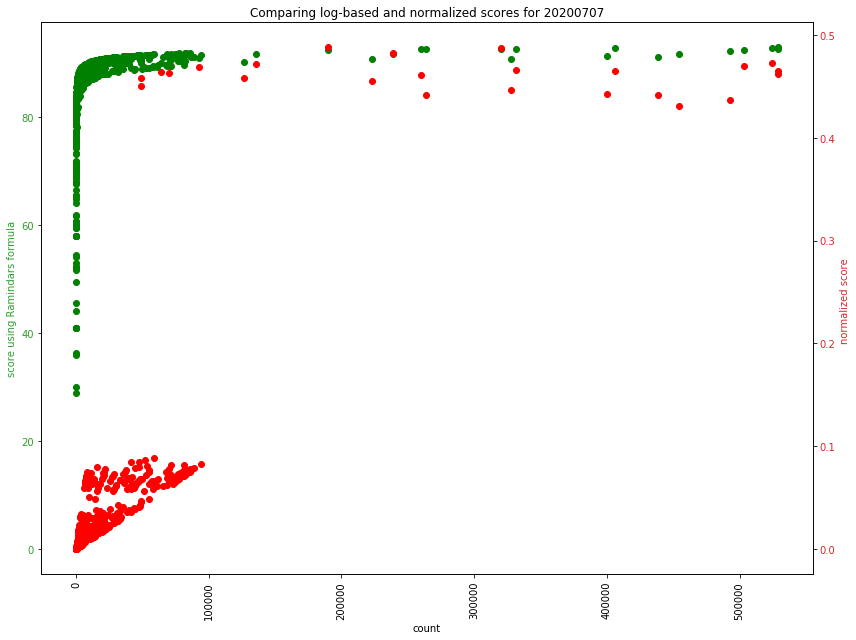

In [8]:
# showing count vs score, count vs normalized_score
x = list(count)
y1 = list(score )
y2 = list(normalized_score )
# plt.plot(x,y1,'r',x,y2,'b')
# plt.show()

fig, ax1 = plt.subplots(figsize=(12,9))  #NOTE: size is in inch! not in pixels!
plt.xticks( rotation='vertical')
color = 'tab:green'
ax1.set_xlabel('count')
ax1.set_ylabel('score using Ramindars formula', color=color)
ax1.plot(x, y1, 'go' )  # markers https://matplotlib.org/3.1.1/api/markers_api.html  color=color, marker='x'
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('normalized score ', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, 'ro')  #color=color, marker='+'
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Comparing log-based and normalized scores for {}".format(day))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [9]:
stat_topic

[{'news': 92.58376958734364,
  'tv': 91.56727050008291,
  'sports': 91.50527798602577,
  'finance': 91.41447985005482,
  'health': 91.39651999945214,
  'lifestyle': 91.38779249209087,
  'foodanddrink': 90.8607312049624,
  'entertainment': 90.82895891472864,
  'movies': 90.73459407253534,
  'autos': 90.6512230652208,
  'music': 90.571456291363,
  'travel': 90.2349267219072,
  'video': 89.76211304981551,
  'weather': 88.56376515389296,
  'kids': 86.87216623708271,
  'latinamerica': 85.58016933219186,
  'northamerica': 83.76374376558152,
  'europe': 76.51532812676322,
  'africa': 58.094021580359474,
  'middleeast': 58.094021580359474,
  'asia': 0.0},
 {'news': 92.57497893837711,
  'sports': 91.50370161105685,
  'tv': 91.4552132439842,
  'lifestyle': 91.36168369639802,
  'finance': 91.33820161691699,
  'health': 91.29974019162248,
  'entertainment': 90.77691279423493,
  'foodanddrink': 90.74080040542627,
  'autos': 90.70872685942554,
  'movies': 90.4556346124536,
  'music': 90.369370366857

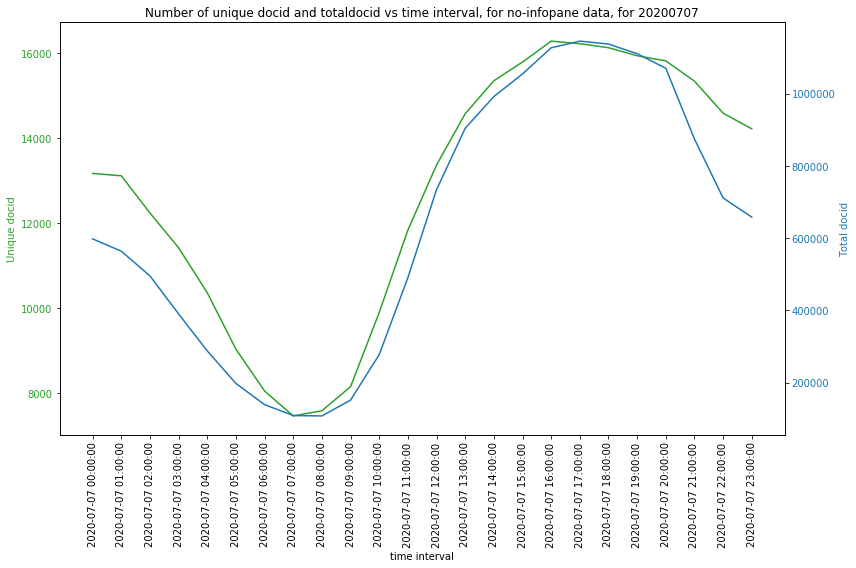

In [10]:
#via https://matplotlib.org/3.2.1/gallery/subplots_axes_and_figures/two_scales.html#:~:text=Two%20plots%20on%20the%20same,the%20two%20axes%20are%20independent.

%matplotlib inline
import matplotlib.pyplot as plt

x = dts[:24]
y1 = unique_docid
y2 = total_docid
# plt.plot(x,y1,'r',x,y2,'b')
# plt.show()

fig, ax1 = plt.subplots(figsize=(12,8))  #NOTE: size is in inch! not in pixels!
plt.xticks( rotation='vertical')
color = 'tab:green'
ax1.set_xlabel('time interval')
ax1.set_ylabel('Unique docid', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total docid', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Number of unique docid and totaldocid vs time interval, for no-infopane data, for {}".format(day))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Analysis itself

In [11]:
topic_list=set()
subtopic_list=set()
for ti in range(len(stat_topic)): #0-23
    topic_list.update( set(stat_topic[0].keys()) )
    subtopic_list.update( set(stat_subtopic[0].keys()) )
print("topic_list:\n{}\ntotal number of topics:  {}".format(topic_list,len(topic_list)))
print()
print("subtopic_list:\n{}\ntotal number of subtopics:  {}".format(subtopic_list,len(subtopic_list)))

topic_list:
{'travel', 'movies', 'northamerica', 'lifestyle', 'latinamerica', 'africa', 'finance', 'europe', 'sports', 'tv', 'video', 'middleeast', 'autos', 'entertainment', 'weather', 'music', 'kids', 'news', 'asia', 'foodanddrink', 'health'}
total number of topics:  21

subtopic_list:
{'asia-top-stories', 'newsfactcheck', 'autosmotorcycles', 'lifestylefashion', 'movievideo', 'basketball_wnba', 'movies', 'viral', 'music-grammys', 'airtravel', 'europe-top-stories', 'lifestyleroyals', 'movienews', 'wellness', 'newsnational', 'cocktails', 'mindandbody', 'animals', 'reviews', 'lifestylecareer', 'lifestylebeauty', 'newsgoodnews', 'people-places', 'awards', 'outdoors', 'autossuvs', 'humor', 'elevate-creativity', 'basketball_nba_videos', 'finance-mutual-funds', 'financenews', 'lifestylehoroscope', 'tvnews', 'racing_motogp', 'tv-awards', 'tunedin', 'newslocalpolitics', 'smallbusiness1', 'sportsphotos', 'yogapilates', 'more_sports', 'voices', 'newsmexico', 'traveltripideas', 'music-reviews', '

In [12]:
topic_scores={} #dict, with key =topic, val=[list of scores per time interval]
for tp in topic_list: #20
    topic_scores[tp]=[] #each topic will have a list of scores, 1 per time int
    for ti in range(len(stat_topic)): #0-23
        if tp in stat_topic[ti]:  #not all topics exist in each time interval
            topic_scores[tp].append( stat_topic[ti][tp] )
        else:
             topic_scores[tp].append( 0 )

subtopic_scores={}
for tp in subtopic_list:
    subtopic_scores[tp]=[] #each subtopic will have a list of scores, 1 per time int
    for ti in range(len(stat_subtopic)): #0-23
        if tp in stat_subtopic[ti]:  #not all subtopics exist in each time interval
           subtopic_scores[tp].append( stat_subtopic[ti][tp] )
        else:
             subtopic_scores[tp].append( 0 )
#print(topic_scores)

In [13]:
# ['news', 'travel', 'finance', 'health', 'tv', 'lifestyle', 'asia', 'foodanddrink', 'autos', 'middleeast', 'weather', 'kids', 'northamerica', 'movies', 'music', 'video', 'latinamerica', 'sports', 'entertainment', 'africa']
len(topic_scores['news'])

24

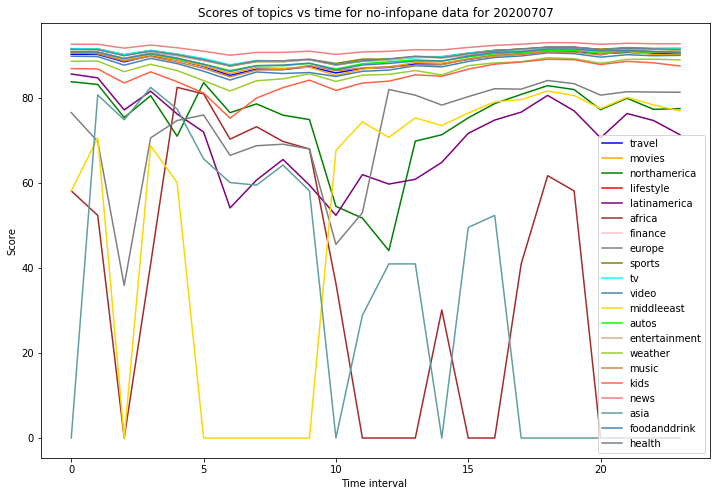

In [14]:
# via https://stackoverflow.com/questions/19189488/use-a-loop-to-plot-n-charts-python/19189664
# 

colours=['blue','orange','green','red','purple', \
         'brown','pink','gray','olive','cyan', \
         'steelblue','gold','lime','tan','yellowgreen', \
         'peru','tomato','lightcoral','cadetblue','steelblue', \
         'slategray','deepskyblue','plum','navy','fushia']
#color names via https://matplotlib.org/3.1.0/gallery/color/named_colors.html
plt.figure(figsize=(12,8)) # In this example, all the plots will be in one figure. 
col=0
for k,v in topic_scores.items():  
    tpk = k
    #print(tpk)
    x=list(range(len(v)))
    y= list(v )
    plt.plot(x,y,colours[col], label=str(tpk))
    plt.title("Scores of topics vs time for no-infopane data for {}".format(day))
    plt.ylabel("Score")
    plt.xlabel("Time interval ")
    plt.legend()
    #plt.ylim((85,95))
    col+=1

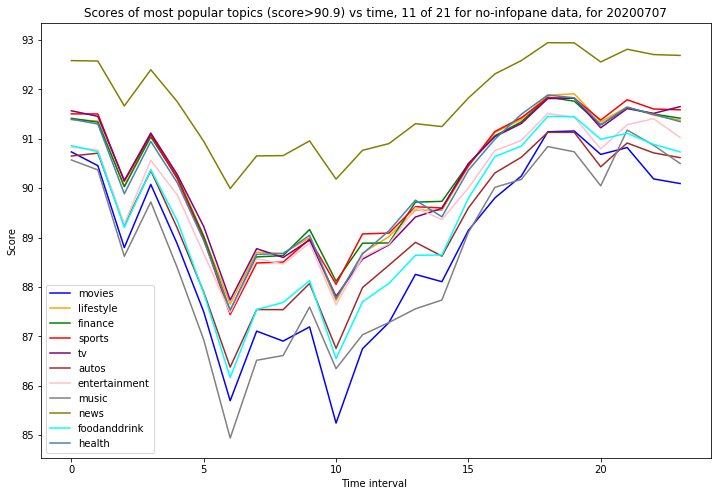

In [15]:
# Show only most popular topics vs time
popularity_limit = 90.9  #found by experiment
dict_top_topics = {}
for k,v in topic_scores.items():
    #print("{}\t{}\t{}".format(k.ljust(12), round(min(v), 2), round(max(v), 2) ) )
    if max(v) > popularity_limit:
        dict_top_topics[k] = v # adding mopular topic to dict
########################

plt.figure(figsize=(12,8)) # In this example, all the plots will be in one figure. 
col=0
for k,v in dict_top_topics.items():  
    tpk = k
    #print(tpk)
    x=list(range(len(v)))
    y= list(v )
    plt.plot(x,y,colours[col], label=str(tpk))
    plt.title("Scores of most popular topics (score>{}) vs time, {} of {} for no-infopane data, for {}".format(popularity_limit, len(dict_top_topics),len(topic_scores), day))
    plt.ylabel("Score")
    plt.xlabel("Time interval ")
    plt.legend()
    #plt.ylim((85,95))
    col+=1

15


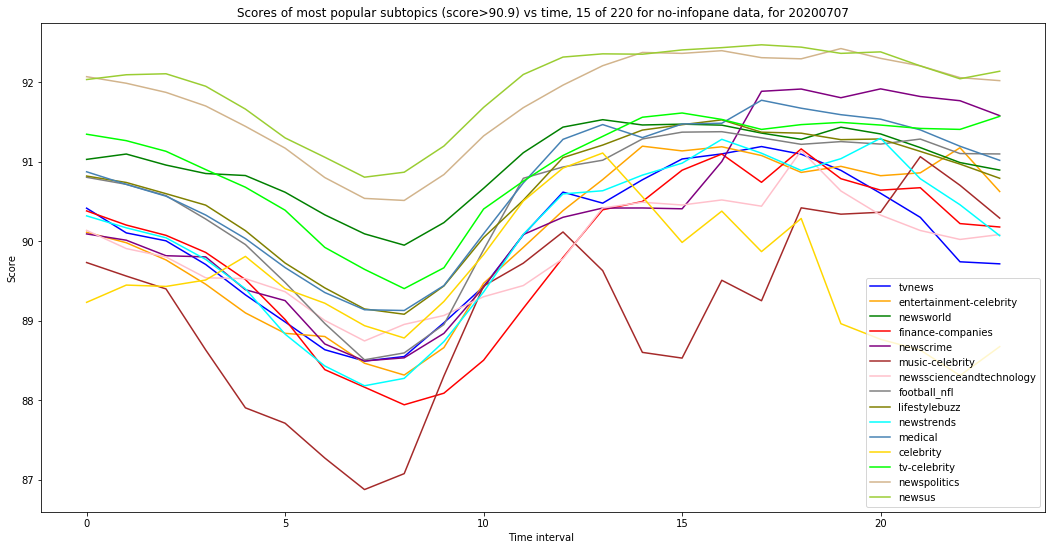

In [17]:
# Show only most popular subtopics vs time
popularity_limit = 90.9  #found by experiment
dict_top_subtopics = {}
for k,v in subtopic_scores.items():
    #print("{}\t{}\t{}".format(k.ljust(32), round(min(v), 2), round(max(v), 2) ) )
    if max(v) > popularity_limit:
        dict_top_subtopics[k] = v # adding mopular topic to dict
print(len(dict_top_subtopics))
########################

plt.figure(figsize=(18,9)) # In this example, all the plots will be in one figure. 
col=0
for k,v in dict_top_subtopics.items():  
    tpk = k
    #print(tpk)
    x=list(range(len(v)))
    y= list(v )
    plt.plot(x,y,colours[col], label=str(tpk))
    plt.title("Scores of most popular subtopics (score>{}) vs time, {} of {} for no-infopane data, for {}".format(popularity_limit, len(dict_top_subtopics),len(subtopic_scores), day))
    plt.ylabel("Score")
    plt.xlabel("Time interval ")
    plt.legend()
    #plt.ylim((85,95))
    col+=1

20


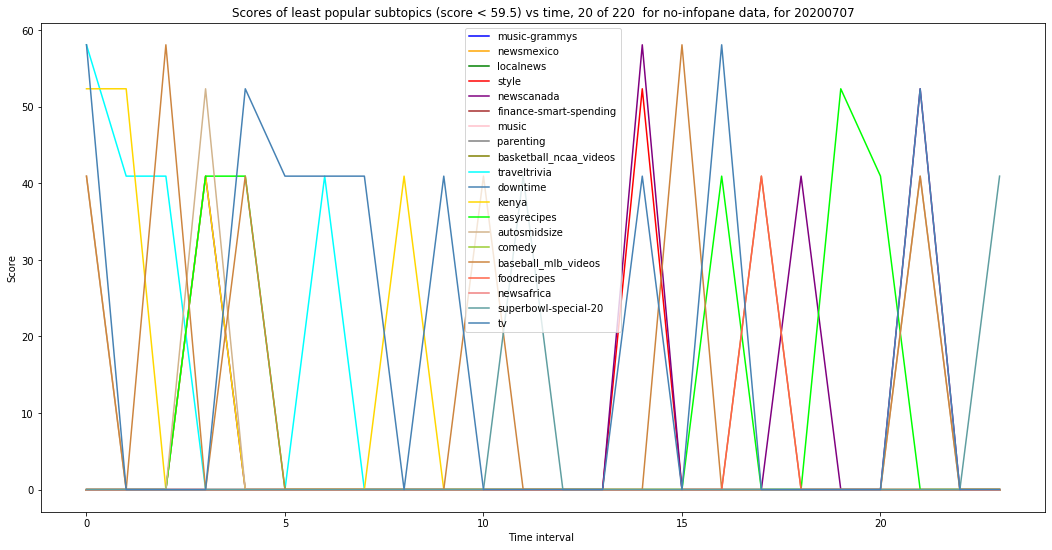

In [18]:
# Show only least popular subtopics vs time
popularity_limit = 59.5  #found by experiment
dict_bottom_subtopics = {}
for k,v in subtopic_scores.items():
    #print("{}\t{}\t{}".format(k.ljust(32), round(min(v), 2), round(max(v), 2) ) )
    if max(v) < popularity_limit:
        dict_bottom_subtopics[k] = v # adding mopular topic to dict
print(len(dict_bottom_subtopics))
########################

plt.figure(figsize=(18,9)) # In this example, all the plots will be in one figure. 
col=0
for k,v in dict_bottom_subtopics.items():  
    tpk = k
    #print(tpk)
    x=list(range(len(v)))
    y= list(v )
    plt.plot(x,y,colours[col], label=str(tpk))
    plt.title("Scores of least popular subtopics (score < {}) vs time, {} of {}  for no-infopane data, for {}".format(popularity_limit, len(dict_bottom_subtopics),len(subtopic_scores), day))
    plt.ylabel("Score")
    plt.xlabel("Time interval ")
    plt.legend()
   # plt.ylim((85,95))
    col+=1